# Time-series outlier detection using Prophet on weather data

## Method

The Prophet outlier detector uses the [Prophet](https://facebook.github.io/prophet/) time series forecasting package explained in [this excellent paper](https://peerj.com/preprints/3190/). The underlying Prophet model is a decomposable univariate time series model combining trend, seasonality and holiday effects. The model forecast also includes an uncertainty interval around the estimated trend component using the [MAP estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) of the extrapolated model. Alternatively, full Bayesian inference can be done at the expense of increased compute. The upper and lower values of the uncertainty interval can then be used as outlier thresholds for each point in time. First, the distance from the observed value to the nearest uncertainty boundary (upper or lower) is computed. If the observation is within the boundaries, the outlier score equals the negative distance. As a result, the outlier score is the lowest when the observation equals the model prediction. If the observation is outside of the boundaries, the score equals the distance measure and the observation is flagged as an outlier. One of the main drawbacks of the method however is that you need to refit the model as new data comes in. This is undesirable for applications with high throughput and real-time detection.

<div class="alert alert-info">
Note

To use this detector, first install Prophet by running:    
```bash
pip install alibi-detect[prophet]
```

This will install Prophet, and its major dependency PyStan. PyStan is currently only [partly supported on Windows](https://pystan.readthedocs.io/en/stable/faq.html?highlight=windows#is-windows-supported). If this detector is to be used on a Windows system, it is recommended to manually install (and test) PyStan before running the command above.

</div>

## Dataset

The example uses a weather time series dataset recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/). The dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. Like the [TensorFlow time-series tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series), we only use data collected between 2009 and 2016.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from alibi_detect.od import OutlierProphet
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.saving import save_detector, load_detector

## Load dataset

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
print(df.shape)
df.head()

(420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Select subset to test Prophet model on:

In [3]:
n_prophet = 10000

Prophet model expects a DataFrame with 2 columns: one named ```ds``` with the timestamps and one named ```y``` with the time series to be evaluated. We will just look at the temperature data:

In [4]:
d = {'ds': df['Date Time'][:n_prophet], 'y': df['T (degC)'][:n_prophet]}
df_T = pd.DataFrame(data=d)
print(df_T.shape)
df_T.head()

(10000, 2)


,ds,y
0,2009-01-01 00:10:00,-8.02
1,2009-01-01 00:20:00,-8.41
2,2009-01-01 00:30:00,-8.51
3,2009-01-01 00:40:00,-8.31
4,2009-01-01 00:50:00,-8.27


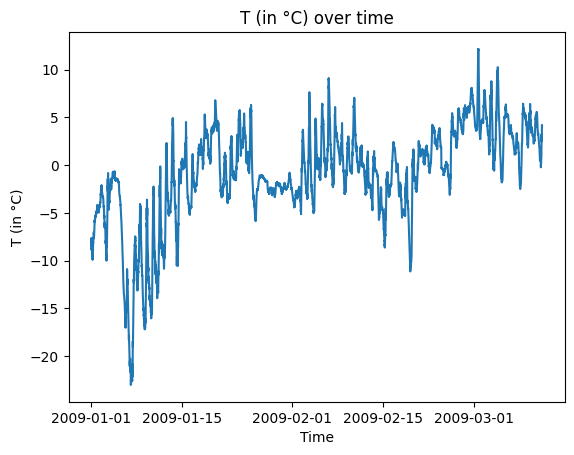

In [5]:
plt.plot(df_T['ds'], df_T['y'])
plt.title('T (in °C) over time')
plt.xlabel('Time')
plt.ylabel('T (in °C)')
plt.show()

## Define outlier detector

We train an outlier detector from scratch:

In [6]:
filepath = 'my_path'  # change to directory where model is saved
detector_name = 'OutlierProphet'
filepath = os.path.join(filepath, detector_name)    

# initialize, fit and save outlier detector
od = OutlierProphet(threshold=.9)
od.fit(df_T)
save_detector(od, filepath)

17:23:40 - cmdstanpy - INFO - Chain [1] start processing
17:23:45 - cmdstanpy - INFO - Chain [1] done processing


Please check out the [documentation](https://docs.seldon.io/projects/alibi-detect/en/stable/od/methods/prophet.html) as well as the original [Prophet documentation](https://facebook.github.io/prophet/) on how to customize the Prophet-based outlier detector and add seasonalities, holidays, opt for a saturating logistic growth model or apply parameter regularization.

## Predict outliers on test data

Define the test data. It is important that the timestamps of the test data follow the training data. We check this below by comparing the first few rows of the test DataFrame with the last few of the training DataFrame:

In [7]:
n_periods = 1000
d = {'ds': df['Date Time'][n_prophet:n_prophet+n_periods], 
     'y': df['T (degC)'][n_prophet:n_prophet+n_periods]}
df_T_test = pd.DataFrame(data=d)
df_T_test.head()

,ds,y
10000,2009-03-11 10:50:00,4.12
10001,2009-03-11 11:00:00,4.62
10002,2009-03-11 11:10:00,4.29
10003,2009-03-11 11:20:00,3.95
10004,2009-03-11 11:30:00,3.96


In [8]:
df_T.tail()

,ds,y
9995,2009-03-11 10:00:00,2.69
9996,2009-03-11 10:10:00,2.98
9997,2009-03-11 10:20:00,3.66
9998,2009-03-11 10:30:00,4.21
9999,2009-03-11 10:40:00,4.19


Predict outliers on test data:

In [9]:
od_preds = od.predict(
    df_T_test, 
    return_instance_score=True,
    return_forecast=True
)

## Visualize results

We can first visualize our predictions with Prophet's built in plotting functionality. This also allows us to include historical predictions:

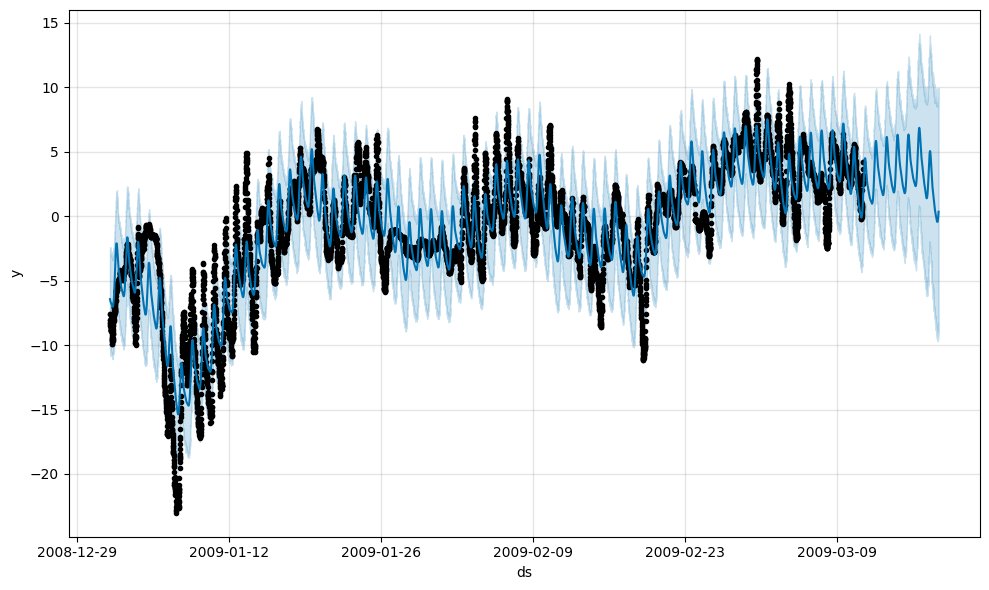

In [10]:
future = od.model.make_future_dataframe(periods=n_periods, freq='10T', include_history=True)
forecast = od.model.predict(future)
fig = od.model.plot(forecast)

We can also plot the breakdown of the different components in the forecast. Since we did not do full Bayesian inference with `mcmc_samples`, the uncertaintly intervals of the forecast are determined by the [MAP estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) of the extrapolated trend.

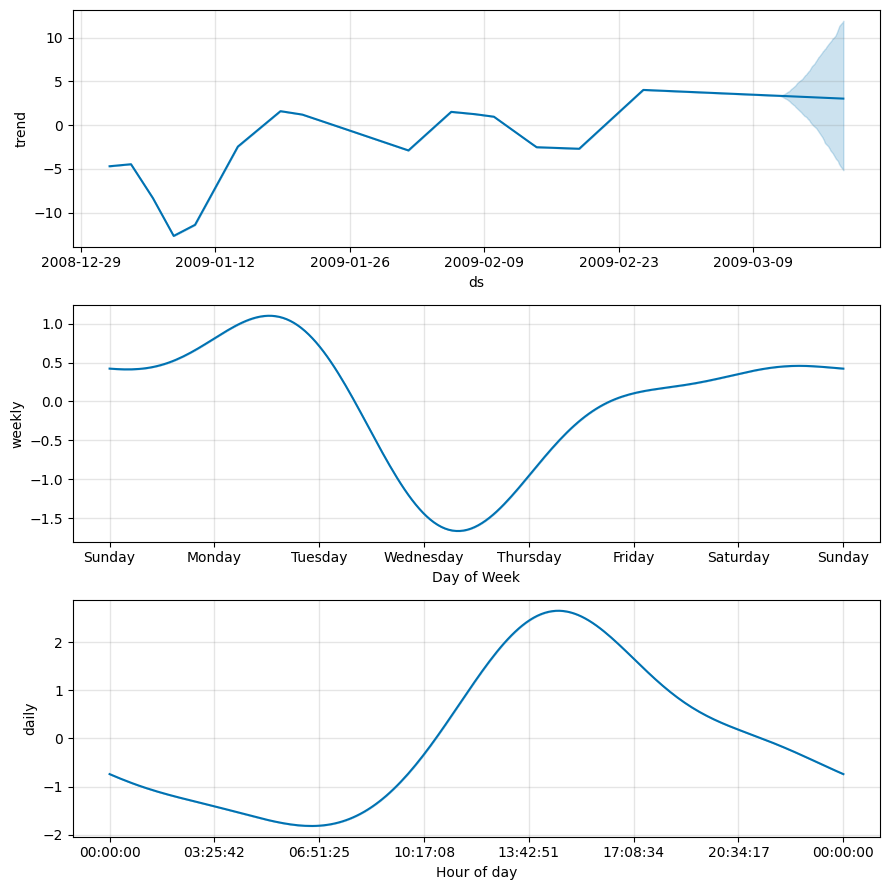

In [11]:
fig = od.model.plot_components(forecast)

It is clear that the further we predict in the future, the wider the uncertainty intervals which determine the outlier threshold.

Let's overlay the actual data with the upper and lower outlier thresholds predictions and check where we predicted outliers:

In [12]:
forecast['y'] = df['T (degC)'][:n_prophet+n_periods]

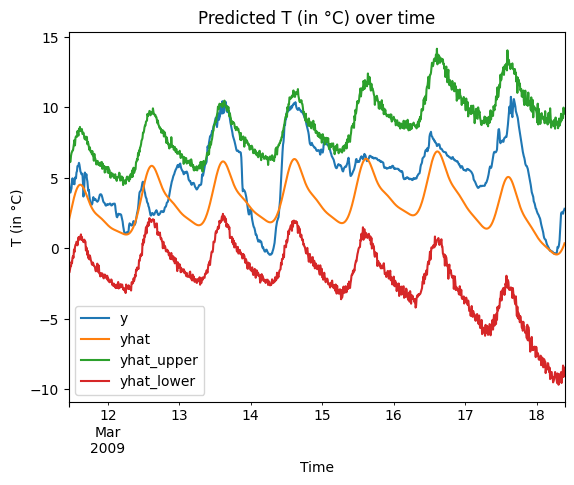

In [13]:
pd.plotting.register_matplotlib_converters()  # needed to plot timestamps
forecast[-n_periods:].plot(x='ds', y=['y', 'yhat', 'yhat_upper', 'yhat_lower'])
plt.title('Predicted T (in °C) over time')
plt.xlabel('Time')
plt.ylabel('T (in °C)')
plt.show()

Outlier scores and predictions:

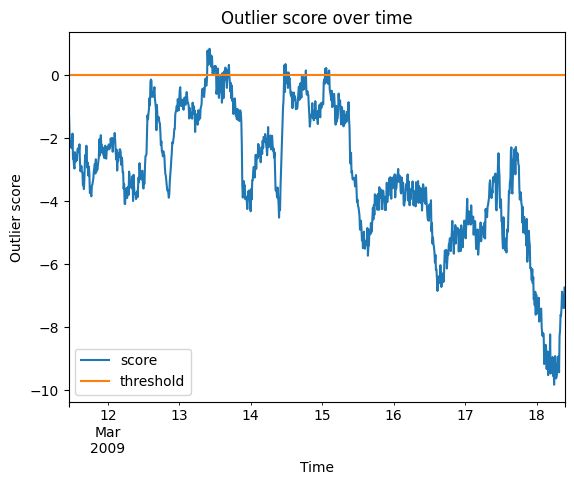

In [14]:
od_preds['data']['forecast']['threshold'] = np.zeros(n_periods)
od_preds['data']['forecast'][-n_periods:].plot(x='ds', y=['score', 'threshold'])
plt.title('Outlier score over time')
plt.xlabel('Time')
plt.ylabel('Outlier score')
plt.show()

The outlier scores naturally trend down as uncertainty increases when we predict further in the future.

Let's look at some individual outliers:

In [15]:
df_fcst = od_preds['data']['forecast']
df_outlier = df_fcst.loc[df_fcst['score'] > 0]

In [16]:
print('Number of outliers: {}'.format(df_outlier.shape[0]))
df_outlier[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y']]

Number of outliers: 37


,ds,yhat,yhat_lower,yhat_upper,y
280,2009-03-13 09:30:00,2.551763,-1.337092,6.429557,7.22
281,2009-03-13 09:40:00,2.666417,-1.105054,6.715948,7.11
282,2009-03-13 09:50:00,2.787416,-1.007419,6.877626,7.22
283,2009-03-13 10:00:00,2.914454,-0.710239,7.115117,7.50
284,2009-03-13 10:10:00,3.047163,-0.878295,6.862116,7.71
285,2009-03-13 10:20:00,3.185116,-0.826350,7.310843,7.93
286,2009-03-13 10:30:00,3.327825,-0.834985,7.323615,7.98
287,2009-03-13 10:40:00,3.474737,-0.828650,7.350005,7.97
288,2009-03-13 10:50:00,3.625238,-0.257963,7.840315,8.11
289,2009-03-13 11:00:00,3.778654,-0.248388,7.703135,8.31
